# READ wine.csv (30%)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
names = ['Type', 'Alcohol','Malic_acid','Ash','Alcalinity_of_ash', 'Magnesium','Total_phenols','Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue','OD280/OD315_of_diluted_wines', 'Proline']
data = pd.read_csv('Wine.csv', names = names)
data.head()

,Type,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Split data

In [0]:
#Writing data into dictionay
wine = {}
for types in range(1,4):
  wine[types] = data[data.Type == types].values

### 1. Split through

```
sklearn.model_selection  train_test_split
```



In [0]:
def ran_split(wine: dict, xtrain: list, xtest: list):
  for types in range(1,4):
    train, test = train_test_split(wine[types], test_size = 18, shuffle =True)
    xtrain.extend(train)
    xtest.extend(test)
  xtrain = np.array(xtrain)
  xtest = np.array(xtest)
  return xtrain, xtest

In [0]:
xtrain, xtest = ran_split(wine, [], [])

In [6]:
xtrain.shape

(124, 14)

In [7]:
xtest.shape

(54, 14)

### 2. Split by hand

In [0]:
def ran_split2(wine: dict, xtrain: list, xtest: list):
  for types in range(1,4):
    seeds = np.random.choice(range(len(wine[types])),size = 18, replace= False)
    for i in range(len(wine[types])):
        if (i in seeds):
          xtest.extend(wine[types][i].reshape(1,-1)) 
        else:
          xtrain.extend(wine[types][i].reshape(1,-1))

  xtrain = np.array(xtrain)
  xtest = np.array(xtest)
  return xtrain, xtest

In [0]:
xtrain2, xtest2 = ran_split2(wine, [], [])

In [10]:
xtrain2.shape

(124, 14)

In [11]:
xtest2.shape

(54, 14)

## Save train.csv and test.csv

In [0]:
Train = pd.DataFrame(xtrain,columns = ['Type', 'Alcohol','Malic_acid','Ash','Alcalinity_of_ash', 'Magnesium','Total_phenols','Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue','OD280/OD315_of_diluted_wines', 'Proline'])
Test = pd.DataFrame(xtest, columns = ['Type', 'Alcohol','Malic_acid','Ash','Alcalinity_of_ash', 'Magnesium','Total_phenols','Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue','OD280/OD315_of_diluted_wines', 'Proline'] )

Train.to_csv('Train.csv', index = False)
Test.to_csv('Test.csv', index = False)

# Evaluate the Posterior Probabilities and Camparing with MAP (50%)

In [0]:
def modify_data(train, test):
  ytrain = train.T[0]
  xtrain = train[:,1:]
  ytest = test.T[0]
  xtest = test[:,1:]
  return xtrain, xtest, ytrain, ytest

## Evaluate Prior distribution

$$ p(Class 1) = \frac{C1}{C1+C2+C3} $$
$$ p(Class 2) = \frac{C2}{C1+C2+C3} $$
$$ p(Class 3) = \frac{C3}{C1+C2+C3} $$


In [0]:
def cal_prior(train): 
  prior_1 = len(train[ytrain == 1])/ len(train)
  prior_2 = len(train[ytrain == 2])/ len(train)
  prior_3 = len(train[ytrain == 3])/ len(train)
  return prior_1, prior_2, prior_3

In [15]:
xtrain, xtest, ytrain, ytest = modify_data(xtrain, xtest)
prior_1, prior_2, prior_3 = cal_prior(ytrain)
print(prior_1, prior_2, prior_3)

0.33064516129032256 0.4274193548387097 0.24193548387096775


## Learning likelihood function 

Using <font color=#0099ff face="Times">***probablity densinty distribution***</font> of <font color=#0099ff face="Times"> ***Guassian Distribution*** </font> to learn likelihooh function of each class. 

Because there are 13 features in this case ,we use  <font color=#FF0000 face="Times" size = 5>  ***Multivariate Guassian Distribution*** </font>

<br>$$P(x;\mu, \Sigma) =  \frac{1}{( 2\pi )^{D/2} \times |\Sigma| ^{1/2}} \times \exp (-\frac {1}{2} \times {(x-\mu)^{T}} \cdot \Sigma^{-1}  \cdot (x - \mu))  $$      
<br>
* $ D$ : dimension of $x$ (features)

* $ \mu = \frac{1}{n} {\sum_1^n}x$

* $ \Sigma = Covariance(x),　size = (D,D)$






In [0]:
## sampling data with multivariate guassian distribution
def multivariate_guassian(x, d, mean, sigma):
  x = x.reshape(13,1)
  exp = (np.exp((-1/2) * (x-mean).T @ np.linalg.inv(sigma) @ (x - mean))).item()
  return (1 / (2 * np.pi)** (d/2) ) * np.sqrt(np.linalg.det(sigma)) *exp

### To learn likelihood function of each group, we have to estimate their parameters $\mu$ and $\Sigma$

In [0]:
def parameters(x: np.array):
  mean = (np.sum(x, axis = 0) / len(x)).reshape(13,1)
  cov = np.cov(x.T)
  return mean, cov

#### $\mu$ and $\Sigma$ of Class 1

In [18]:
mean, cov = parameters(xtrain[:41,:])
print(mean)
print(cov)

[[1.37968293e+01]
 [2.08097561e+00]
 [2.46170732e+00]
 [1.68878049e+01]
 [1.06487805e+02]
 [2.86926829e+00]
 [3.01512195e+00]
 [2.86341463e-01]
 [1.95463415e+00]
 [5.62414634e+00]
 [1.06073171e+00]
 [3.15000000e+00]
 [1.13517073e+03]]
[[ 2.40882195e-01 -9.80932927e-03 -1.38444512e-02 -4.80914634e-01
   8.90085366e-01  7.73401220e-02  9.81991463e-02  4.03060976e-03
   7.91750610e-02  2.51290976e-01  4.80237805e-03  2.03500000e-03
   3.06158049e+01]
 [-9.80932927e-03  5.30304024e-01  3.68829268e-03  8.69871951e-02
   7.00262195e-01 -2.91067683e-02 -6.81876220e-02 -7.06884146e-03
  -4.74396341e-02 -2.60249146e-01 -3.55032317e-02  6.22325000e-02
  -6.83431707e+01]
 [-1.38444512e-02  3.68829268e-03  3.68945122e-02  2.08396341e-01
   4.24396341e-01  1.09878049e-03  8.21036585e-04  1.68890244e-03
   4.01890244e-04  9.27524390e-03  5.85121951e-03 -9.68750000e-03
   2.11695122e+00]
 [-4.80914634e-01  8.69871951e-02  2.08396341e-01  5.86609756e+00
   2.39859756e+00 -1.72609146e-01 -2.83260976e-0

#### $\mu$ and $\Sigma$ of Class 2

In [19]:
mean, cov = parameters(xtrain[41:94,:])
print(mean)
print(cov)

[[1.22862264e+01]
 [2.07716981e+00]
 [2.25396226e+00]
 [2.05471698e+01]
 [9.27735849e+01]
 [2.26622642e+00]
 [2.15188679e+00]
 [3.69056604e-01]
 [1.66830189e+00]
 [3.06452830e+00]
 [1.04150943e+00]
 [2.88603774e+00]
 [4.91188679e+02]]
[[ 3.55854717e-01 -1.01089623e-02 -5.27905298e-02 -2.87010885e-01
  -5.16255443e-01 -3.81510522e-02 -5.04388970e-02 -7.88439768e-03
  -9.53296081e-02  1.63075109e-01 -1.94996372e-03 -6.93363933e-02
  -1.80062046e+00]
 [-1.01089623e-02  1.24667453e+00  4.07960450e-02  6.64751451e-01
  -8.89306967e-01  5.66794993e-02  8.76708273e-02  1.81530479e-02
   1.57152794e-01 -2.04156168e-01 -9.73514151e-02  2.68481858e-02
  -2.52398403e+01]
 [-5.27905298e-02  4.07960450e-02  9.88705370e-02  6.93386430e-01
   1.92645138e-01  2.09479318e-02  7.04250726e-02  1.57403483e-02
  -6.44314224e-03  7.04517417e-03 -5.37340348e-03  1.64486938e-02
   8.08417997e-03]
 [-2.87010885e-01  6.64751451e-01  6.93386430e-01  9.67061684e+00
  -5.02565312e+00  3.91429608e-02  5.13928520e-0

#### $\mu$ and $\Sigma$ of Class 3

In [20]:
mean, cov = parameters(xtrain[94:,:])
print(mean)
print(cov)

[[1.31760000e+01]
 [3.27900000e+00]
 [2.43600000e+00]
 [2.18000000e+01]
 [9.89666667e+01]
 [1.66533333e+00]
 [8.28000000e-01]
 [4.23666667e-01]
 [1.18800000e+00]
 [7.45733330e+00]
 [6.69666667e-01]
 [1.63666667e+00]
 [6.21500000e+02]]
[[ 3.56238621e-01 -7.16455172e-02  1.98282759e-02  2.50551724e-01
  -1.24013793e+00  6.01772414e-02  8.15379310e-03  1.28358621e-02
   1.20998621e-01  6.03085531e-01 -2.69103448e-03  3.25551724e-02
  -7.39551724e+00]
 [-7.16455172e-02  1.20629207e+00 -4.25075862e-02 -8.60689655e-02
  -4.68382759e+00 -9.93393103e-02 -1.82708966e-01  5.90831034e-02
  -1.55719310e-01 -1.14753376e+00  3.89306897e-02 -1.21034483e-02
  -9.67431034e+00]
 [ 1.98282759e-02 -4.25075862e-02  3.15144828e-02  3.17620690e-01
   5.12275862e-01  4.10565517e-02  2.59400000e-02  2.69448276e-03
   4.43710345e-02  1.91457936e-01 -1.35655172e-03 -5.68965517e-03
  -1.44206897e+00]
 [ 2.50551724e-01 -8.60689655e-02  3.17620690e-01  5.28620690e+00
   2.68275862e+00  3.98000000e-01  2.07862069e-0

## Calculate Posterior and the accuracy rate of the MAP detector

$$Posterior( P(C1|x) ) = \frac{P(x|C1) \times P(c1)}{𝑃 (𝑥|𝐶1)\times𝑃(𝐶1) + 𝑃 (𝑥|𝐶2)\times 𝑃(𝐶2) + P(x|c3)\times P(C3)} $$

<br>



*   Likelihood function: $  P(x|C1), P(x|C2), P(x|C3) $

*   Prior: $ P(C1), P(C2), P(C3) $



random splite from raw data

In [0]:
train, test = ran_split(wine,[], [])
xtrain, xtest, ytrain, ytest = modify_data(train, test)
prior_1, prior_2, prior_3 = cal_prior(ytrain)

class1_x = xtrain[:41,:]
class2_x = xtrain[41:94,:]
class3_x = xtrain[94:,:]

mean, cov = parameters(class1_x)
mean2, cov2 = parameters(class2_x)
mean3, cov3 = parameters(class3_x)

In [22]:
acc_seeds = 0
clas = 0

for i in range(len(xtest)):
  t = xtest[i]

  posterior_1 = (multivariate_guassian(t,13,mean,cov)*prior_1) / (multivariate_guassian(t,13,mean,cov)*prior_1 + multivariate_guassian(t,13,mean2,cov2)*prior_2 + multivariate_guassian(t,13,mean3,cov3)*prior_3)
  posterior_2 = (multivariate_guassian(t,13,mean2,cov2)*prior_2) / (multivariate_guassian(t,13,mean,cov)*prior_1 + multivariate_guassian(t,13,mean2,cov2)*prior_2 + multivariate_guassian(t,13,mean3,cov3)*prior_3)
  posterior_3 = (multivariate_guassian(t,13,mean3,cov3)*prior_3) / (multivariate_guassian(t,13,mean,cov)*prior_1 + multivariate_guassian(t,13,mean2,cov2)*prior_2 + multivariate_guassian(t,13,mean3,cov3)*prior_3)

  good = max(posterior_1, posterior_2, posterior_3)


  if (good == posterior_1):
    clas = 1
  elif (good == posterior_2):
    clas = 2
  else:
    clas = 3
  print('%d. is belong to class %d with posterior = %f \t\t posterior of each class = %f, %f, %f' % (i+1,clas,good, posterior_1, posterior_2, posterior_3) )

  
  if (clas == ytest[i]):
    acc_seeds += 1
    print('\t Correctly Classify\n\n')

1. is belong to class 1 with posterior = 0.999999 		 posterior of each class = 0.999999, 0.000001, 0.000000
	 Correctly Classify


2. is belong to class 1 with posterior = 0.535840 		 posterior of each class = 0.535840, 0.464160, 0.000000
	 Correctly Classify


3. is belong to class 1 with posterior = 1.000000 		 posterior of each class = 1.000000, 0.000000, 0.000000
	 Correctly Classify


4. is belong to class 1 with posterior = 0.999994 		 posterior of each class = 0.999994, 0.000006, 0.000000
	 Correctly Classify


5. is belong to class 1 with posterior = 0.999136 		 posterior of each class = 0.999136, 0.000864, 0.000000
	 Correctly Classify


6. is belong to class 2 with posterior = 0.830869 		 posterior of each class = 0.169131, 0.830869, 0.000000
7. is belong to class 2 with posterior = 0.914389 		 posterior of each class = 0.085611, 0.914389, 0.000000
8. is belong to class 1 with posterior = 0.999842 		 posterior of each class = 0.999842, 0.000158, 0.000000
	 Correctly Classify


In [23]:
print('Accuracy Rate = %f' % (acc_seeds/len(ytest)))

Accuracy Rate = 0.925926


# Discussion Characteristics and Plot the Visualized Result of Testing Data(20%)

## 2-Dim PCA Visualization

In [0]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components=2 )
pca.fit(xtest)

new_xtest = pca.transform(xtest)
new_xtest

array([[ 5.26610183e+02,  1.03513126e+01],
       [-1.83295528e+01,  1.88191644e+01],
       [ 4.41117367e+02, -1.51621655e+01],
       [ 2.81300829e+02, -4.08132853e+00],
       [ 2.36364165e+02, -2.04207129e-01],
       [ 9.12271937e+01, -5.24523957e+00],
       [ 1.31447150e+02,  4.75163610e+00],
       [ 3.76544708e+02,  8.21020927e+00],
       [ 5.31393439e+02, -1.91272792e+00],
       [ 7.61296988e+02, -8.14360010e+00],
       [ 6.96443128e+02, -1.15749738e+00],
       [ 1.61431339e+02,  4.33514165e+00],
       [ 9.16355523e+01,  1.43557576e+01],
       [ 3.66562410e+02,  9.44330067e+00],
       [ 1.66291118e+02, -2.68888173e+00],
       [ 2.61181931e+02, -9.61764580e+00],
       [ 7.93246331e+02, -1.31780782e+01],
       [ 5.36164081e+02, -1.40803196e+01],
       [ 2.31989249e+02,  3.56085917e+01],
       [-4.01872982e+02, -5.76481471e+00],
       [-4.41743487e+02,  8.60443051e-01],
       [-2.33834447e+02, -7.60396531e+00],
       [-4.28833841e+02, -3.25779895e+00],
       [-4.

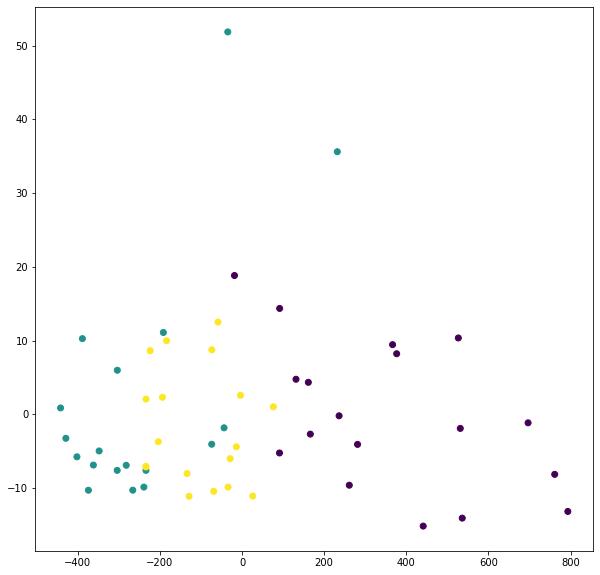

In [26]:
plt.figure(figsize=(10,10))
plt.scatter(new_xtest[:,0], new_xtest[:,1], c=ytest, marker='o')

## 3-Dim PCA Visualization

In [0]:
from mpl_toolkits.mplot3d import Axes3D

In [28]:
pca3d = PCA(n_components=3)
pca3d.fit(xtest)
new_xtest3d = pca3d.transform(xtest)
new_xtest3d

array([[ 5.26610183e+02,  1.03513126e+01, -1.68826277e+00],
       [-1.83295528e+01,  1.88191644e+01,  1.66293793e-01],
       [ 4.41117367e+02, -1.51621655e+01,  1.59125091e+00],
       [ 2.81300829e+02, -4.08132853e+00,  2.53617782e+00],
       [ 2.36364165e+02, -2.04207129e-01,  2.20908585e+00],
       [ 9.12271937e+01, -5.24523957e+00,  5.96246542e-02],
       [ 1.31447150e+02,  4.75163610e+00,  2.75536577e+00],
       [ 3.76544708e+02,  8.21020927e+00, -1.27145964e+00],
       [ 5.31393439e+02, -1.91272792e+00,  8.31093455e-01],
       [ 7.61296988e+02, -8.14360010e+00, -2.60373963e+00],
       [ 6.96443128e+02, -1.15749738e+00,  1.57591970e+00],
       [ 1.61431339e+02,  4.33514165e+00,  4.76622904e-01],
       [ 9.16355523e+01,  1.43557576e+01,  4.67228041e+00],
       [ 3.66562410e+02,  9.44330067e+00, -1.54091373e+00],
       [ 1.66291118e+02, -2.68888173e+00, -1.00664120e+00],
       [ 2.61181931e+02, -9.61764580e+00,  1.19542405e+00],
       [ 7.93246331e+02, -1.31780782e+01

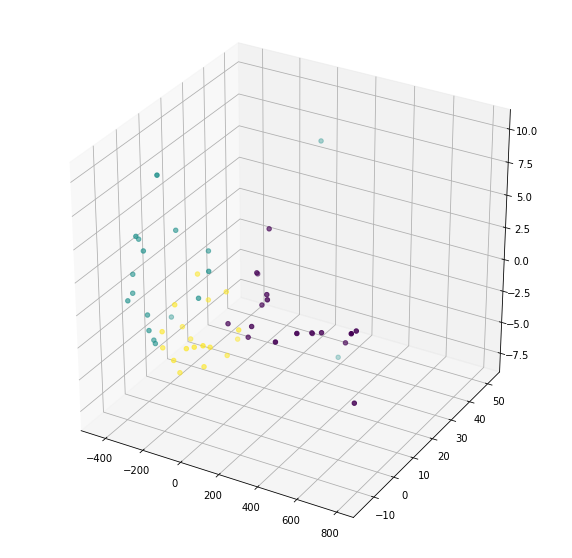

In [29]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_xtest3d[:,0], new_xtest3d[:,1], zs = new_xtest3d[:,2], c=ytest)

## Characteristics of Data

In [0]:
train, test = ran_split(wine,[], [])
xtrain, xtest, ytrain, ytest = modify_data(train, test)

In [31]:
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [32]:
xgbc.predict(xtest)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 3.,
       3., 3., 3.])

<BarContainer object of 13 artists>

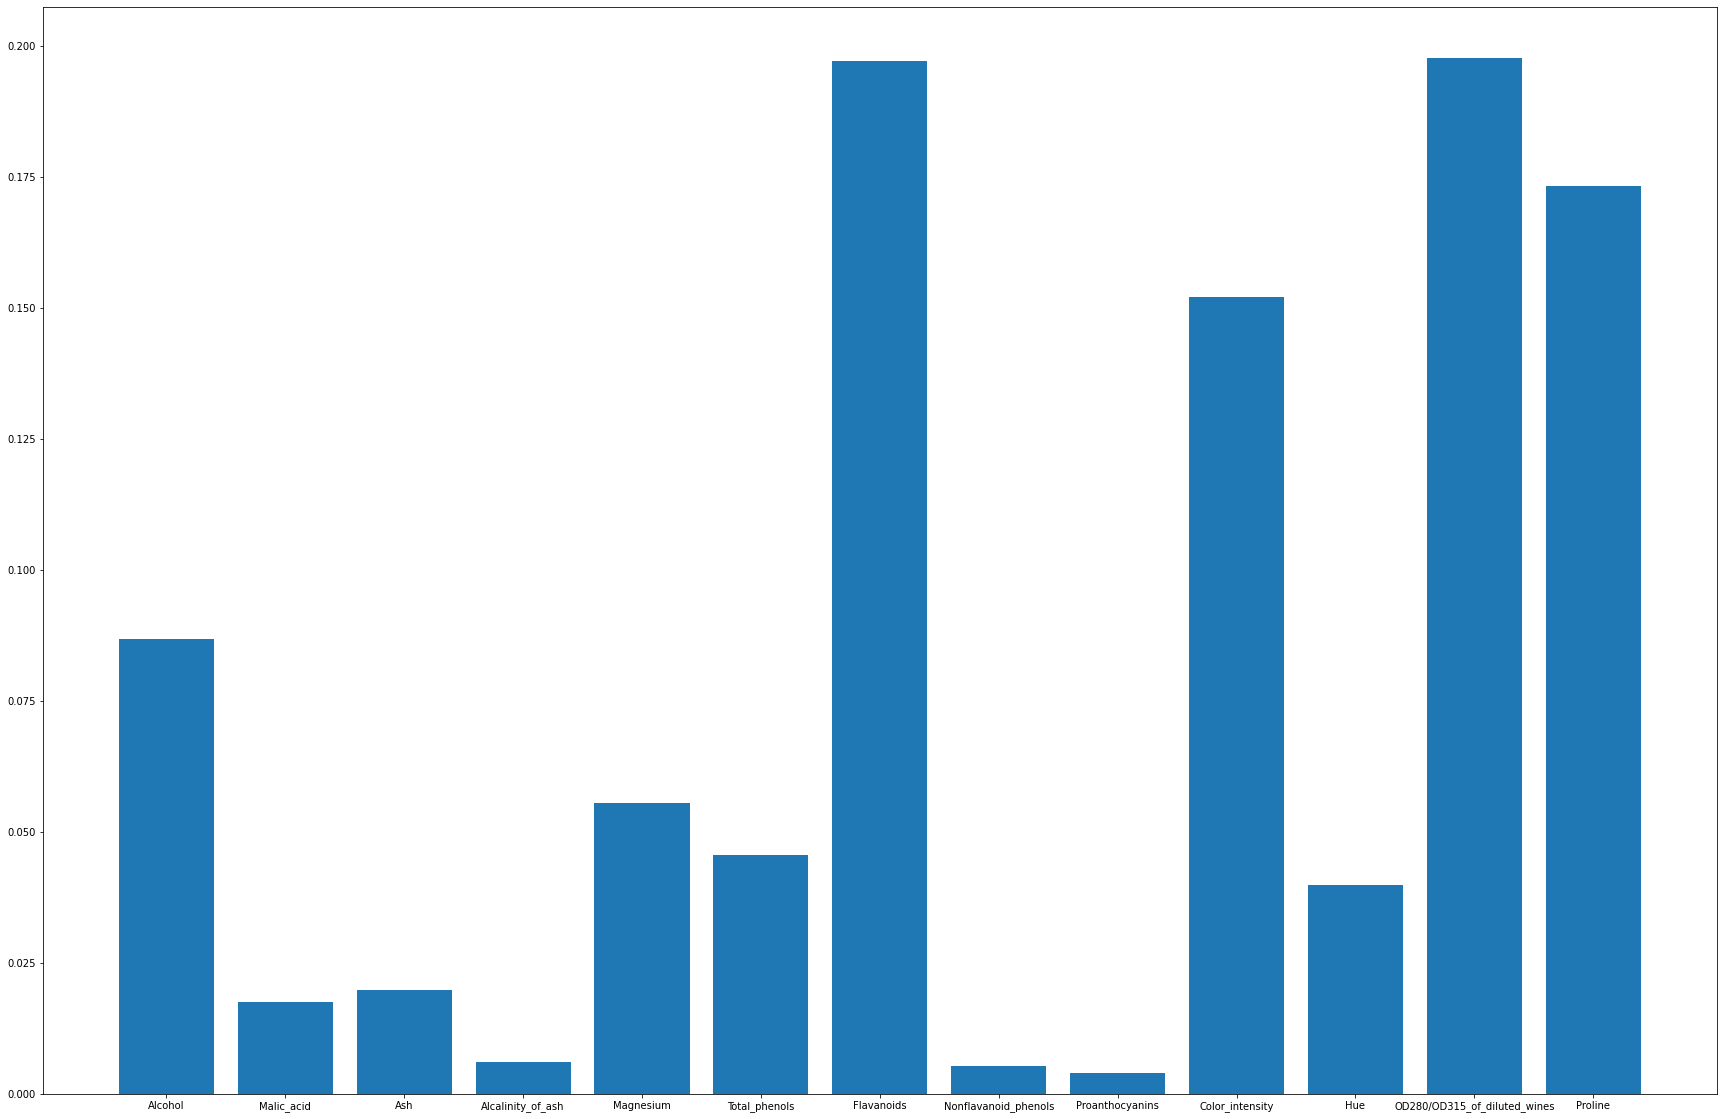

In [33]:
plt.figure(figsize=(30,20))
plt.bar([ 'Alcohol',
 'Malic_acid',
 'Ash',
 'Alcalinity_of_ash',
 'Magnesium',
 'Total_phenols',
 'Flavanoids',
 'Nonflavanoid_phenols',
 'Proanthocyanins',
 'Color_intensity',
 'Hue',
 'OD280/OD315_of_diluted_wines',
 'Proline'], xgbc.feature_importances_ )